In [10]:
import qiskit
# numerics
import numpy as np
# functional programming tools
import itertools
import functools
import operator
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 125
import seaborn
# data analysis
import pandas as pd
# qiskit 
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import QasmSimulator, AerSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Kraus, SuperOp, SparsePauliOp, Operator, DensityMatrix, Statevector
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error
from qiskit.circuit import ParameterVector

## Exercise 4.1

In [11]:
#Circuit 1: Single CNOT gate
circ_1=list([list((0,3))])
circ_2=list([list((0,1)), list((2,3)), list((0,3)), list((1,2))])

def create_CNOT_circuit(CNOT_list):
    qc = QuantumCircuit(4)
    
    # Apply the Ising-type gates for each edge
    for item in CNOT_list:
        qc.cx(item[0], item[1])
    return qc

### 4.1 (a)

In [20]:
#Algorithm:
from collections import deque, defaultdict

def build_adj_list(edges):
    graph = defaultdict(list)
    for u, v in edges:
        graph[u].append(v)
    return graph


def find_shortest_path(graph, start, end):

    # BFS Initialization
    queue = deque([[start]])  # Store all paths
    visited = {start}

    while queue:
        path = queue.popleft()
        node = path[-1]

        if node == end:
            return path  # Find the shortest path from start to end

        for neighbor in graph[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(path + [neighbor])
    
    return None  # No path exist


def qubit_routing_algorithm(CNOT_list, mapping):
    qc = QuantumCircuit(4)
    cnot_count=0
    #To Do: Write an algorithm that creates the circuit in the given topology using swap gates 
    # and evaluates the cnot count of the resulting circuit
    neighbour_on_path = False
    output_cnot_list = []
    graph = build_adj_list([(i, i+1) for i in range(3)] + [(i+1, i) for i in range(3)])
    mapping_dict = {}
    for (u, v) in mapping:
        mapping_dict[u] = v
    physical_cnot_list = [(mapping_dict[u], mapping_dict[v]) for (u, v) in CNOT_list]
    # print(graph)
    for (u, v) in physical_cnot_list:
        if v in graph[u]:
            cnot_count += 1
            output_cnot_list.append((u, v))
        else:
            if neighbour_on_path:
                path = find_shortest_path(graph, u, v)
                path = path[:-1]
                neighbour = path[-1]  # Find the neighbour on the shortest path from u to v
            else:
                neighbour = graph[v][0]  # Pick a neighbour of v, always pick the first one
                path = find_shortest_path(graph, u, neighbour)
            
            swap = []
            path_length = len(path)
            for i in range(path_length - 1):
                swap += [(path[i], path[i+1]), (path[i+1], path[i]), (path[i], path[i + 1])]
            output_cnot_list += swap + [(neighbour, v)] + swap[::-1]    
            cnot_count += 6 * len(path) - 5   
            # assert len(swap) == 3 * len(path) - 3
    qc = create_CNOT_circuit(output_cnot_list)
    return qc, cnot_count

### 4.1 (b)

Consider the following CNOT gate and the intuitive qubit mapping $q_i \rightarrow q_i$ :

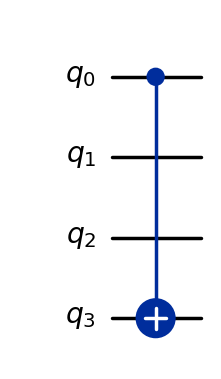

In [21]:
mapping_1 = [(0,0), (1,1), (2,2), (3,3)]

qc=create_CNOT_circuit(circ_1)
qc.draw('mpl')

CNOT count: 13


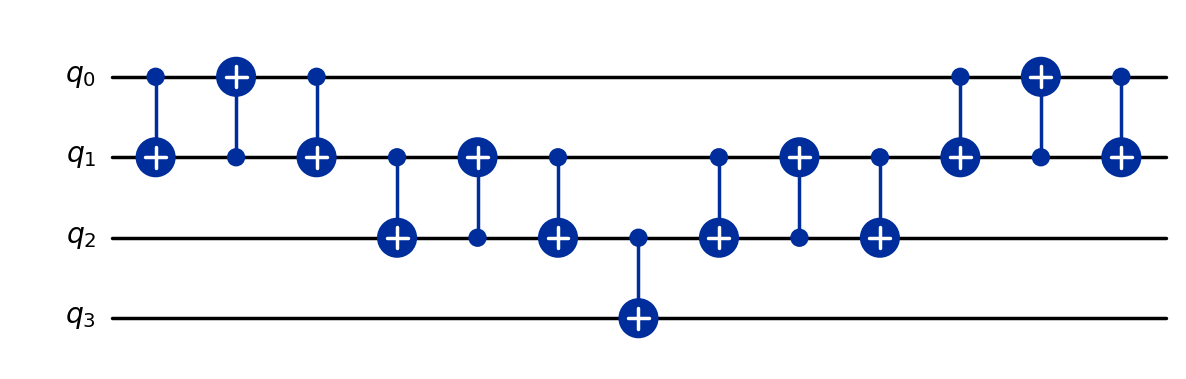

In [22]:
#To Do: Run your algorithm for a single CNOT gate in the given topology
qc, cnot_count = qubit_routing_algorithm(circ_1, mapping_1)

print(f"CNOT count: {cnot_count}")

qc.draw('mpl')

## 4.1 (c)

Consider the following CNOT circuit

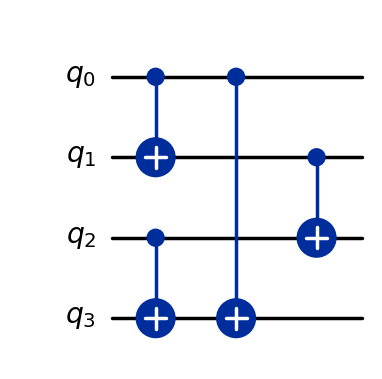

In [23]:
qc=create_CNOT_circuit(circ_2)
qc.draw('mpl')

CNOT count: 16


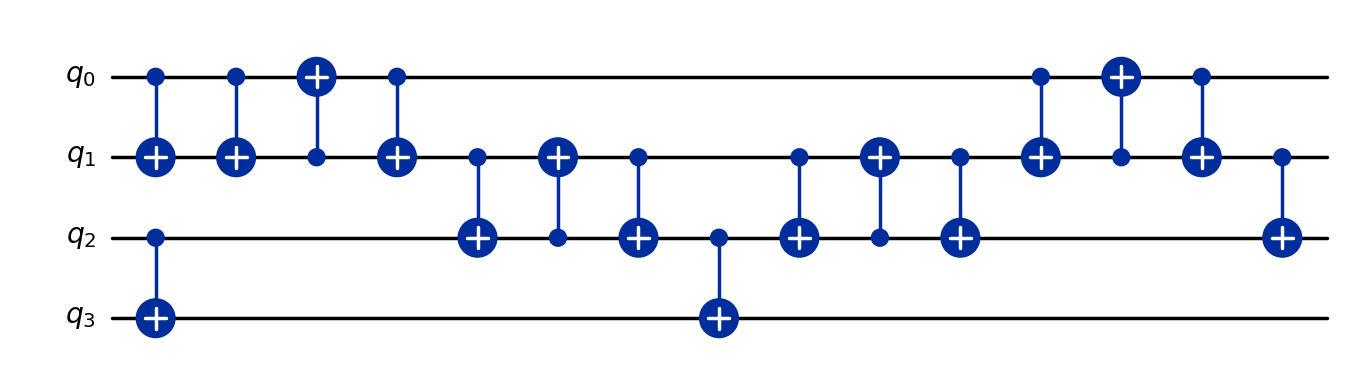

In [24]:
#To Do: Run your algorithm with the intuitive mapping for the above CNOT circuit
qc, cnot_count = qubit_routing_algorithm(circ_2, mapping_1)
print(f"CNOT count: {cnot_count}")
qc.draw('mpl')

## 4.1 (d)

CNOT count: 28


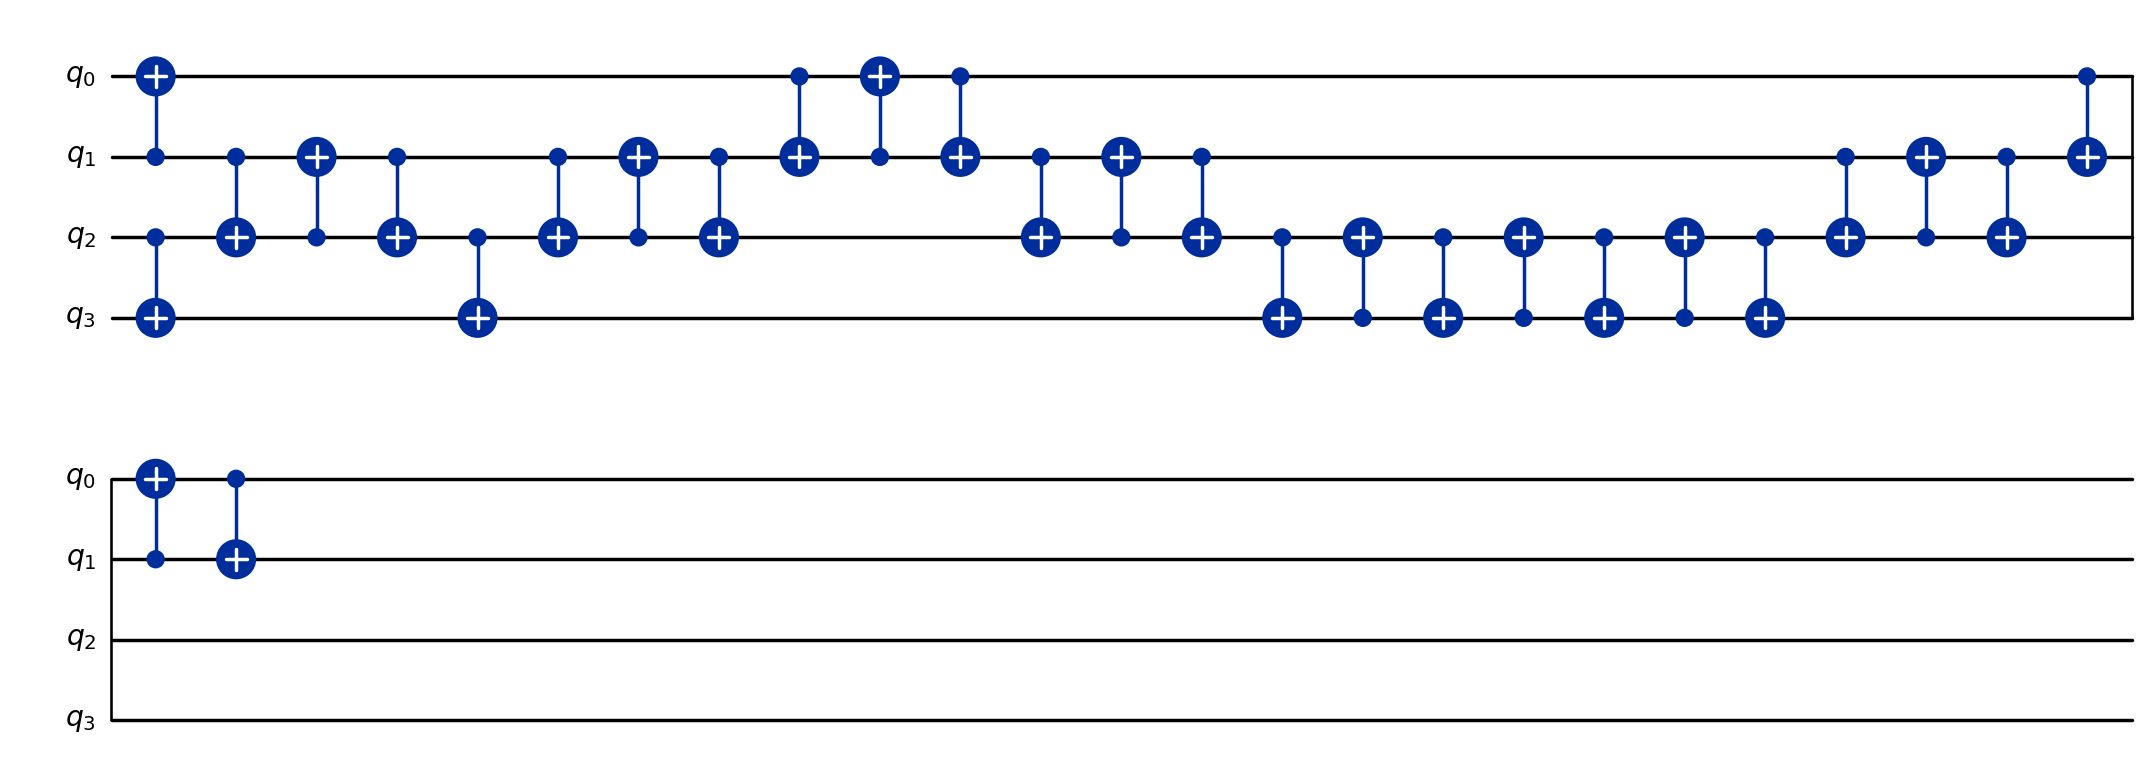

In [25]:
mapping_2 = [(0,1), (1,0), (2,2), (3,3)]

#To Do: Run the algorithm with another mapping

qc, cnot_count = qubit_routing_algorithm(circ_2, mapping_2)
print(f"CNOT count: {cnot_count}")
qc.draw('mpl')

### Difference
It requires more CNOT gates, because of the difference in mapping and the choose of the neighbour. If we always pick the "first" neighbour, the length of the SWAP network is larger. We have also experimented with choosing a neighbour that is right on the shortest path between the nodes. In that case it is the same, that 16 CNOT gates are required. This can be done by setting `neighbour_on_path` to `True` in line 37 on the block below 4.1.(a)

## 4.1 (e)

CNOT count: 40


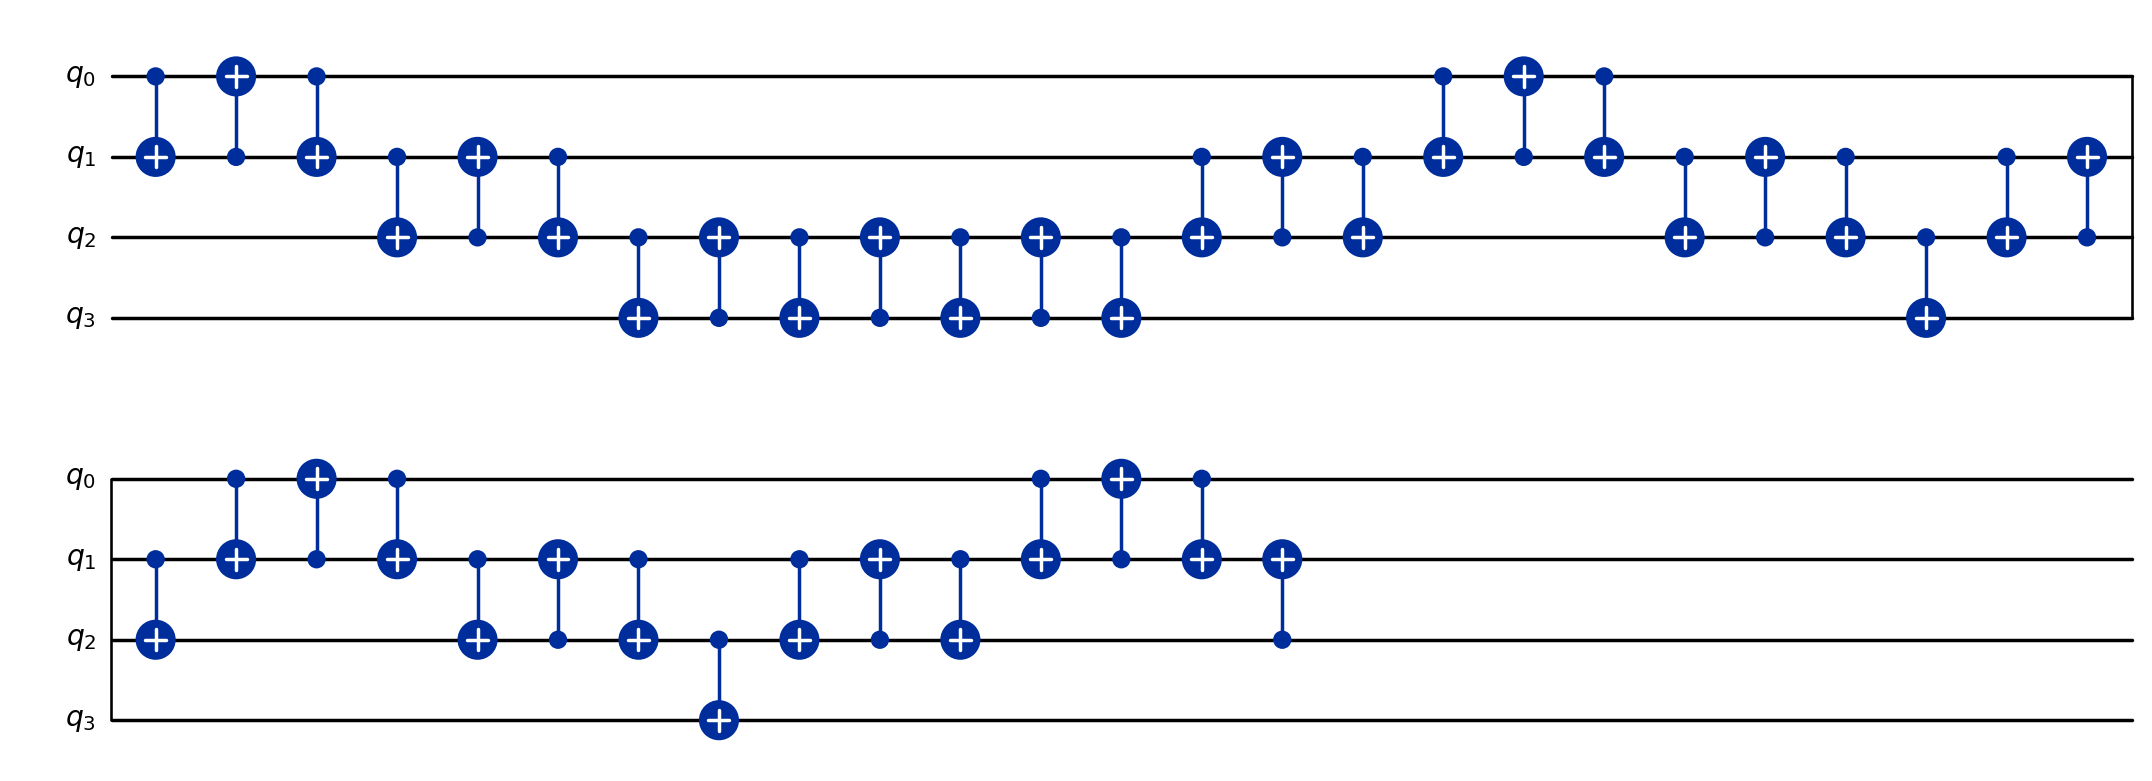

In [26]:
mapping_3 = [(0,0), (1,2), (2,1), (3,3)]

#To Do: Run the algorithm with another mapping
qc, cnot_count = qubit_routing_algorithm(circ_2, mapping_3)
print(f"CNOT count: {cnot_count}")
qc.draw('mpl')

### Difference
In this mapping more CNOT gates are needed, because $(q_0, q_1)$ and $(q_2, q_3)$ become $(q_0, q_2)$ and $q_1, q_3)$ on physical layout, so that the distance between them is further than the intuitive qubit mapping.